# PS6

MACS 30100 Dr. Evens

Jie Heng

In [24]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
df = pd.read_csv('biden.csv')
df.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


## Problem 1 Decision trees 

### (a)   Split the data into a training set (70%) and a test set (30%). Be sure to set your seed prior to this part of your code to guarantee reproducibility of results. Use recursive binary splitting to ﬁt a decision tree to the training data, with biden as the response variable and the other variables as predictors. Plot the tree and interpret the results. What is the test MSE? 

In [25]:
y = df['biden'].values
X = df[['female', 'age', 'educ', 'dem', 'rep']].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3,
                                                    random_state=25)

In [27]:
biden_tree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=3)
biden_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

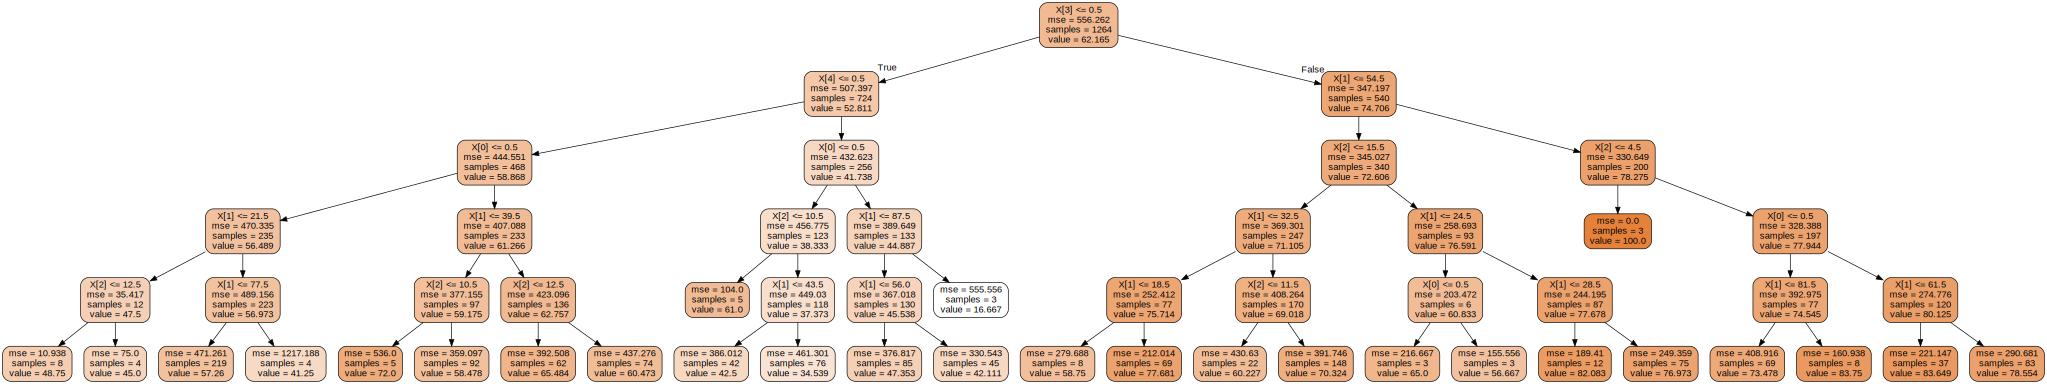

In [28]:
biden_viz = export_graphviz(biden_tree, out_file=None, rounded=True, filled=True)
graph = graphviz.Source(biden_viz)
graph.render('biden_viz')
graph

In [29]:
y_pred = biden_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 406.67204914577894


X[0] = female, X[1] = age, X[2] = educ, X[3] = dem, X[4] = rep

From the graph we know that females and Democrats are more likley to like Biden more. Here, I would explain the first three layers. 

The first branch is if people are democrat or not. In general Democrats like Biden more than non-Democrats. 

For non-Democrats, the next cut is if they are Republicans. Republicans like Biden less than central voters(not Democrats or Repblicans). For non-Democrats, the next cut gender(female) does make some difference. Female repuplicans like Biden more than male republicans. Female central voters also like Biden more than male central voters.

For Democrats, the second cut is age. Older Democrats voters(more than 54.5) are more likely to support Biden. Among older voters, female Democrats voters like Biden more than male. For younger Democrats voters, people who have received more than 15.5 years education like Biden more.

### (b)   Leave the control options for tree() at their default values. Now ﬁt another tree to the training data with the following control options: tree(control = tree.control(nobs = # number of rows in the training set, mindev = 0)) Use cross-validation to determine the optimal level of tree complexity, plot the optimal tree, and interpret the results. Does pruning the tree improve the test MSE?

In [30]:
l = []
for i in range(1,20):
    biden_tree2 = DecisionTreeRegressor(min_samples_leaf = 5, max_depth = i)
    biden_tree2.fit(X_train, y_train)
    y_pred2 = biden_tree2.predict(X_test)
    MSE2 = mean_squared_error(y_test, y_pred2)
    l.append(MSE2)
    print('with max_depth {}, MSE = {}'.format(i, MSE2))

with max_depth 1, MSE = 420.0224529349668
with max_depth 2, MSE = 400.06539818418173
with max_depth 3, MSE = 396.1937146321307
with max_depth 4, MSE = 404.59602362340974
with max_depth 5, MSE = 411.80592737244535
with max_depth 6, MSE = 420.7201303515671
with max_depth 7, MSE = 438.0607513503332
with max_depth 8, MSE = 464.8931449707398
with max_depth 9, MSE = 462.3674415271974
with max_depth 10, MSE = 468.4803016091758
with max_depth 11, MSE = 470.8457788064336
with max_depth 12, MSE = 478.51904267404984
with max_depth 13, MSE = 479.27865636134834
with max_depth 14, MSE = 480.08124128311744
with max_depth 15, MSE = 481.6763693013289
with max_depth 16, MSE = 482.8423688503198
with max_depth 17, MSE = 480.55067869359414
with max_depth 18, MSE = 480.6980083436862
with max_depth 19, MSE = 480.55067869359414


In [31]:
print('Using a max_depth =', l.index(min(l)) + 1, 'results in the lowest MSE level', min(l))

Using a max_depth = 3 results in the lowest MSE level 396.1937146321307


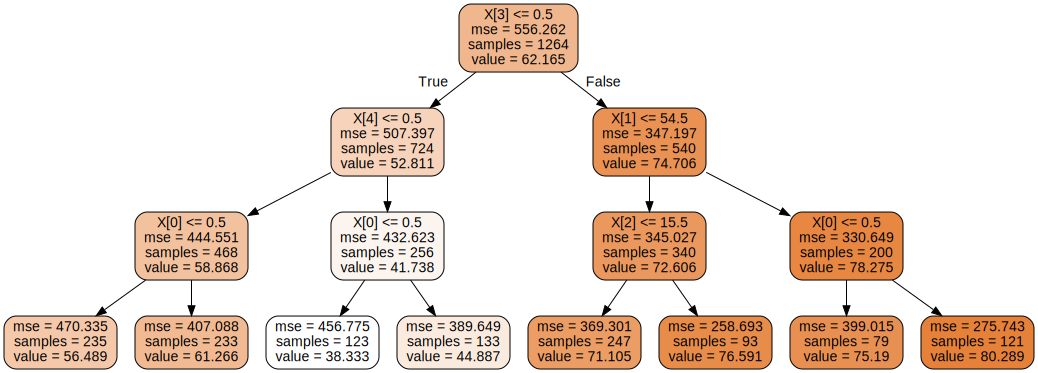

In [32]:
biden_tree2 = DecisionTreeRegressor(min_samples_leaf=5, max_depth=3)
biden_tree2.fit(X_train, y_train)
biden_tree_viz2 = export_graphviz(
    biden_tree2,
    out_file=None,
    rounded=True,
    filled=True,
)
graph = graphviz.Source(biden_tree_viz2)
graph.render('biden_tree_viz2')
graph

X[0] = female, X[1] = age, X[2] = educ, X[3]= dem, X[4] = rep

The pruned tree has reduced MSE, so pruning improves MSE. The tree is the same with question a, so my interpretation stays the same.

### (c)   Use the bagging approach to estimate a tree to create a model for predicting biden. What test MSE do you obtain? Obtain variable importance measures and interpret the results.

In [33]:
biden_tree3 = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                             max_samples=100, bootstrap=True, oob_score=True, random_state=15)
biden_tree3.fit(X, y)
biden_tree3.score(X, y)
y_pred3 = biden_tree3.oob_prediction_
MSE3 = mean_squared_error(y, y_pred3)
print('MSE=', MSE3)

MSE= 406.0005583949261


In [34]:
importances = np.mean([tree.feature_importances_ for tree in biden_tree3.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
features = ['female', 'age', 'dem', 'rep', 'educ']
for f in range(X.shape[1]):
    print(f+1, features[f],str(importances[indices[f]]))

Feature ranking:
1 female 0.4429127039606069
2 age 0.20057625971613363
3 dem 0.19032354439169072
4 rep 0.10602822551257896
5 educ 0.06015926641898977


From the feature ranking, we know that female is the most important variable in the tree model, followed by age, dem, rep and educ.

### (d)  Use the random forest approach to estimate a tree to create a model for predicting biden. Do this for m = 1, m = 2, and m = 3 (the number of variables). What test MSE do you obtain in each case? Obtain variable importance measures and interpret the results. Describe the eﬀect of m, the number of variables considered at each split, on the error rate obtained.

In [35]:
def getMSE(max_features, X, y):
    biden_tree = RandomForestRegressor(max_features = max_features, n_estimators=53,  bootstrap=True,
                                  oob_score=True, random_state=15)
    biden_tree.fit(X, y)
    biden_tree.score(X, y)
    y_pred = biden_tree.oob_prediction_
    MSE = mean_squared_error(y, y_pred)
    importances = biden_tree.feature_importances_
    std = np.std([tree.feature_importances_ for tree in biden_tree.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    print('m =', max_features,'Feature Ranking:')
    for i in range(X.shape[1]):
        print(i+1, features[i], ": ",str(importances[indices[i]]))
    print('')
    return MSE

In [36]:
print('m = 1, we get MSE=', getMSE(1, X, y))

m = 1 Feature Ranking:
1 female :  0.5121750986284854
2 age :  0.1924320716293704
3 dem :  0.15018054715372878
4 rep :  0.12387921818323255
5 educ :  0.021333064405182765

m = 1, we get MSE= 532.8750579722736


In [37]:
print('m = 2, we get MSE=', getMSE(2, X, y))

m = 2 Feature Ranking:
1 female :  0.5075843112401004
2 age :  0.1919435140428256
3 dem :  0.1514236956156639
4 rep :  0.1279439072674188
5 educ :  0.02110457183399131

m = 2, we get MSE= 538.192542935064


In [38]:
print('m = 3, we get MSE=', getMSE(3, X, y))

m = 3 Feature Ranking:
1 female :  0.4846520363670528
2 age :  0.19916532223909172
3 dem :  0.16508946236227023
4 rep :  0.1237223793449543
5 educ :  0.027370799686630812

m = 3, we get MSE= 535.7619627008756


The above results show that female is the most important variable, same with part c. The ordering of features ranking does not change when m changes -- females is followed by age, dem and educ. When m =1, we get the smallest MSE.